# GFG Data Scientist Task - Exploratory data analysis (EDA) 

This Jupyter Notebook gives a flavor of my thought process while exploring the data

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [2]:
# Read the json file provided on the github page

df_json = pd.read_json('data.json', orient='record')

In [3]:
# Create the dataframe

df_raw = pd.read_json(df_json.iloc[0,0], orient='record')

### High-level exploratory analysis

In [4]:
# Shape of the original dataframe

df_raw.shape

(191287, 33)

In [5]:
# Make sure there is no missing value

df_raw.isna().sum()

days_since_first_order      0
days_since_last_order       0
is_newsletter_subscriber    0
orders                      0
items                       0
returns                     0
different_addresses         0
shipping_addresses          0
devices                     0
vouchers                    0
cc_payments                 0
paypal_payments             0
afterpay_payments           0
female_items                0
male_items                  0
unisex_items                0
wapp_items                  0
wftw_items                  0
mapp_items                  0
wacc_items                  0
macc_items                  0
mftw_items                  0
sprt_items                  0
msite_orders                0
desktop_orders              0
android_orders              0
ios_orders                  0
work_orders                 0
home_orders                 0
parcelpoint_orders          0
coupon_discount_applied     0
revenue                     0
customer_id                 0
dtype: int

In [6]:
# Look at the columns types

df_raw.dtypes

days_since_first_order        int64
days_since_last_order         int64
is_newsletter_subscriber     object
orders                        int64
items                         int64
returns                       int64
different_addresses           int64
shipping_addresses            int64
devices                       int64
vouchers                      int64
cc_payments                   int64
paypal_payments               int64
afterpay_payments             int64
female_items                  int64
male_items                    int64
unisex_items                  int64
wapp_items                    int64
wftw_items                    int64
mapp_items                    int64
wacc_items                    int64
macc_items                    int64
mftw_items                    int64
sprt_items                    int64
msite_orders                  int64
desktop_orders                int64
android_orders                int64
ios_orders                    int64
work_orders                 

In [7]:
# Convert 'is_newsletter_subscriber' into 1 or 0 (1='Yes', 0 ='No').

df_raw['is_newsletter_subscriber'] = np.where(df_raw['is_newsletter_subscriber']=='Y',1,0)

In [8]:
# Check if there is any duplicated customer_id

df_raw['customer_id'].duplicated().sum()

0

In [9]:
# First glance at each column

for i in df_raw.columns:
    print(df_raw[f"{i}"].describe())
    print(' ')

count    191287.000000
mean       2325.415344
std         382.012579
min           3.000000
25%        2271.000000
50%        2414.000000
75%        2526.000000
max        2813.000000
Name: days_since_first_order, dtype: float64
 
count    191287.000000
mean        862.390832
std         832.876737
min           0.000000
25%          92.000000
50%         544.000000
75%        1659.000000
max        2329.000000
Name: days_since_last_order, dtype: float64
 
count    191287.000000
mean          0.661096
std           0.473339
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_newsletter_subscriber, dtype: float64
 
count    191287.000000
mean         10.841887
std          19.191299
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max        1289.000000
Name: orders, dtype: float64
 
count    191287.000000
mean         24.544668
std          50.868840
min           1.000000

In [10]:
print(f"Percentage of customers having ordered an item less than a week ago: {round(df_raw.loc[df_raw['days_since_last_order']<7].shape[0]*100/df_raw.shape[0],1)} %")

Percentage of customers having ordered an item less than a week ago: 4.7 %


#### Remarks from above

- days_since_first_order: This column looks good.
- days_since_last_order: This column looks good also the average of last order is more than 2 years !
- is_newsletter_subscriber: This columns looks ok as well.
- orders: This column looks good.
- items: This looks ok as well.
- returns: This column looks correct although the max is 2022 ! That's a lot of returns. To check in detail later.
- different_addresses: This columns looks ok.
- shipping_addresses: This looks ok although the max of different shipping addresses used is 1122. That's a lot of different addresses. To check in detail later.
- devices: This columns looks fine.
- vouchers: This looks ok to me.
- cc_payments: This columns looks good.
- paypal_payments: Nothing wrong here.
- afterpay_payments: All good here.
- female_items: This column looks fine.
- male_items: Nothing wrong that I can spot there.
- unisex_items: All good for me.
- wapp_items: Looks good.
- wftw_items: This columns looks good as well.
- mapp_items: Nothing wrong here either.
- wacc_items: Ok also.
- macc_items: Looks fine.
- mftw_items: Looks just fine as well.
- sprt_items: This is looking good too.
- msite_orders: Nothing much here.
- desktop_orders: Pretty normal as well.
- android_orders: This looks good.
- ios_orders: This column is fine.
- work_orders: Pretty normal too.
- home_orders: This looks good.
- parcelpoint_orders: This column is ok.
- <font color=red> __coupon_discount_applied:__ </font> 'coupon_discount_applied' is the average discount rate applied via coupon based discount e.g. SAVE15. It does not make sense to have negative values or values exceeding 100%. We will need to clean this column.
- <font color=red> __revenue:__ </font> The column 'revenue' is the amount of $ Dollar spent overall per person. Customers are not supposed to spend negative amount of money when purchasing goods. We will need to clean this column as well.
- customer_id: This column loos fine.


__Conclusion:__ <br/>It looks like the 2 columns that need some work (as specified in the problem formulation) are __revenue__ and __coupon_discount_applied__.
<br/>Also, there are outliers in numerous columns and some weird values here and there. It might be better to get rid of them to fit our model later on.

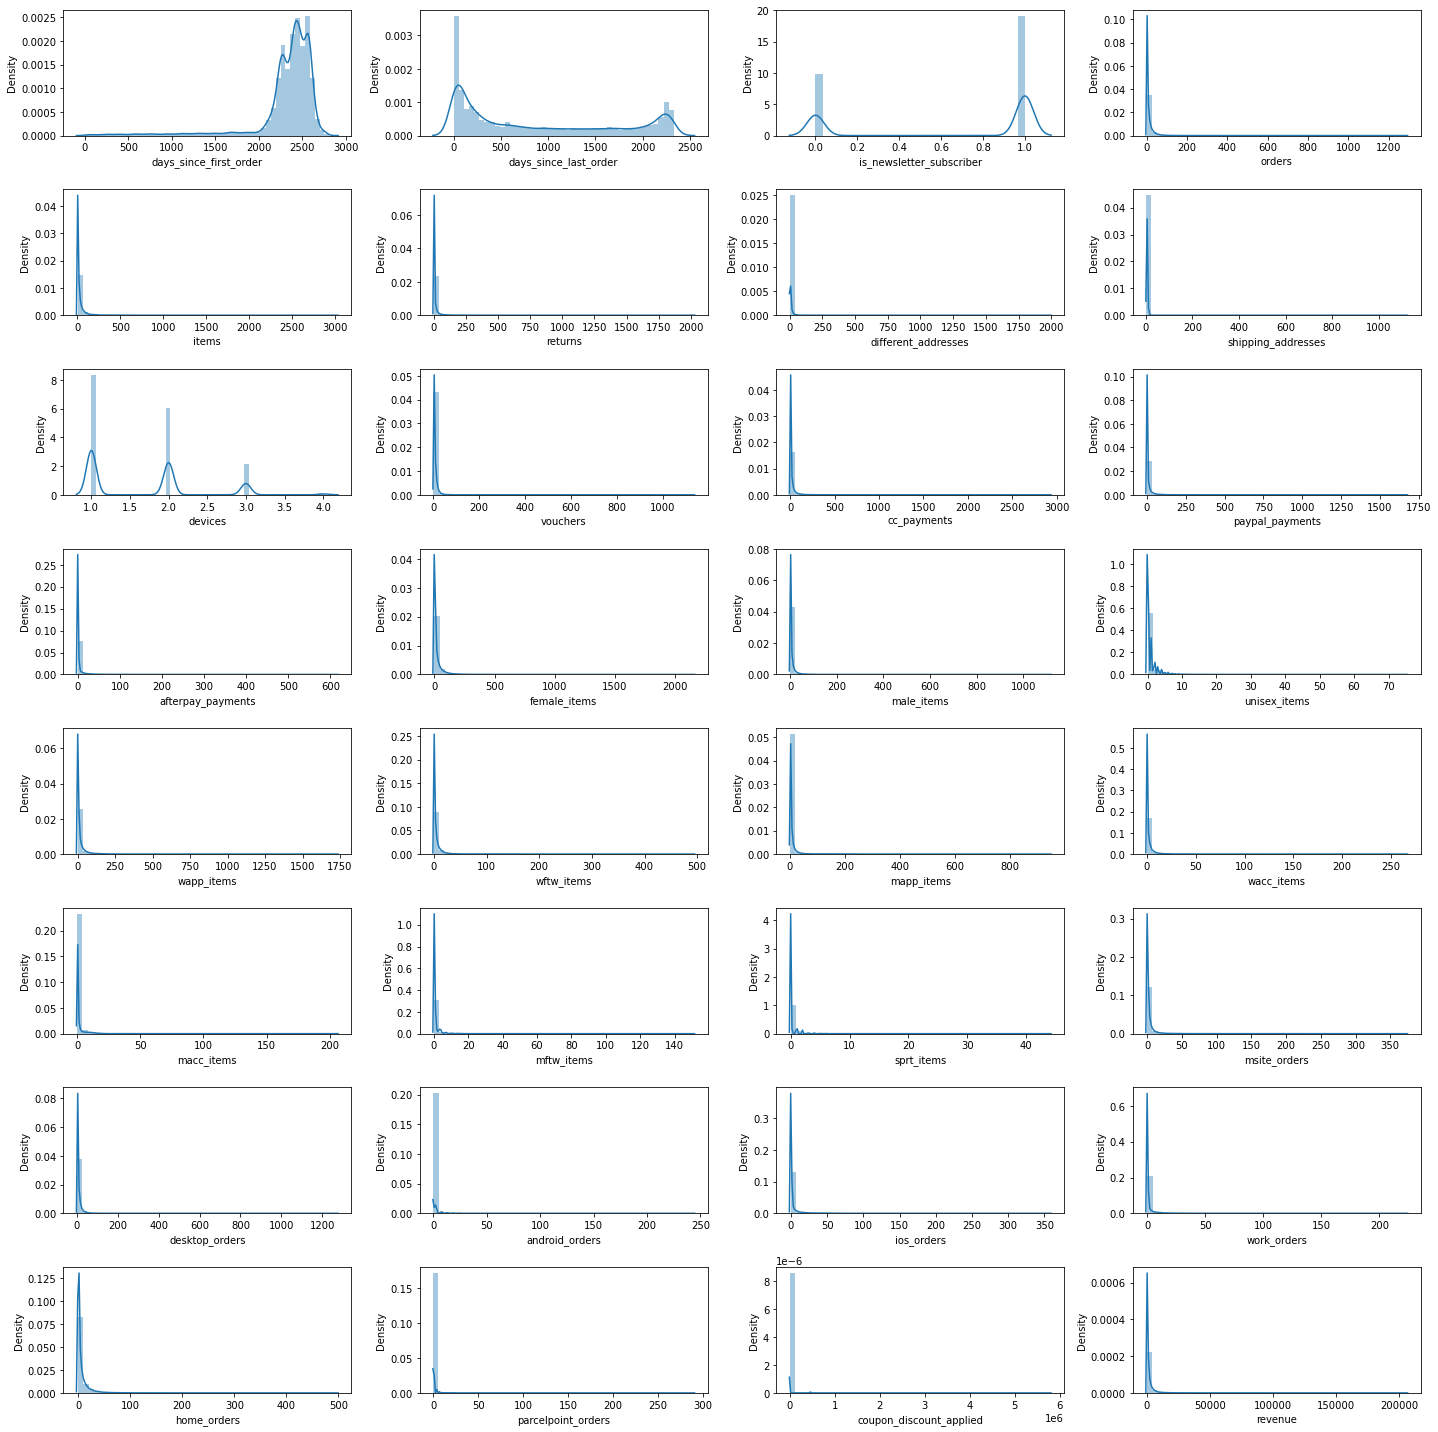

In [11]:
# Print histogram for all columns except customer_id.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

to_remove = ['customer_id']
print_list = [ x for x in df_raw.columns.tolist() if x not in to_remove]

f, axes = plt.subplots(8,4, figsize=(20,20))

for index, col in enumerate(print_list):
    i, j = divmod(index,4)
    sns.distplot(df_raw[f"{col}"],ax=axes[i, j])

plt.tight_layout()
plt.show()

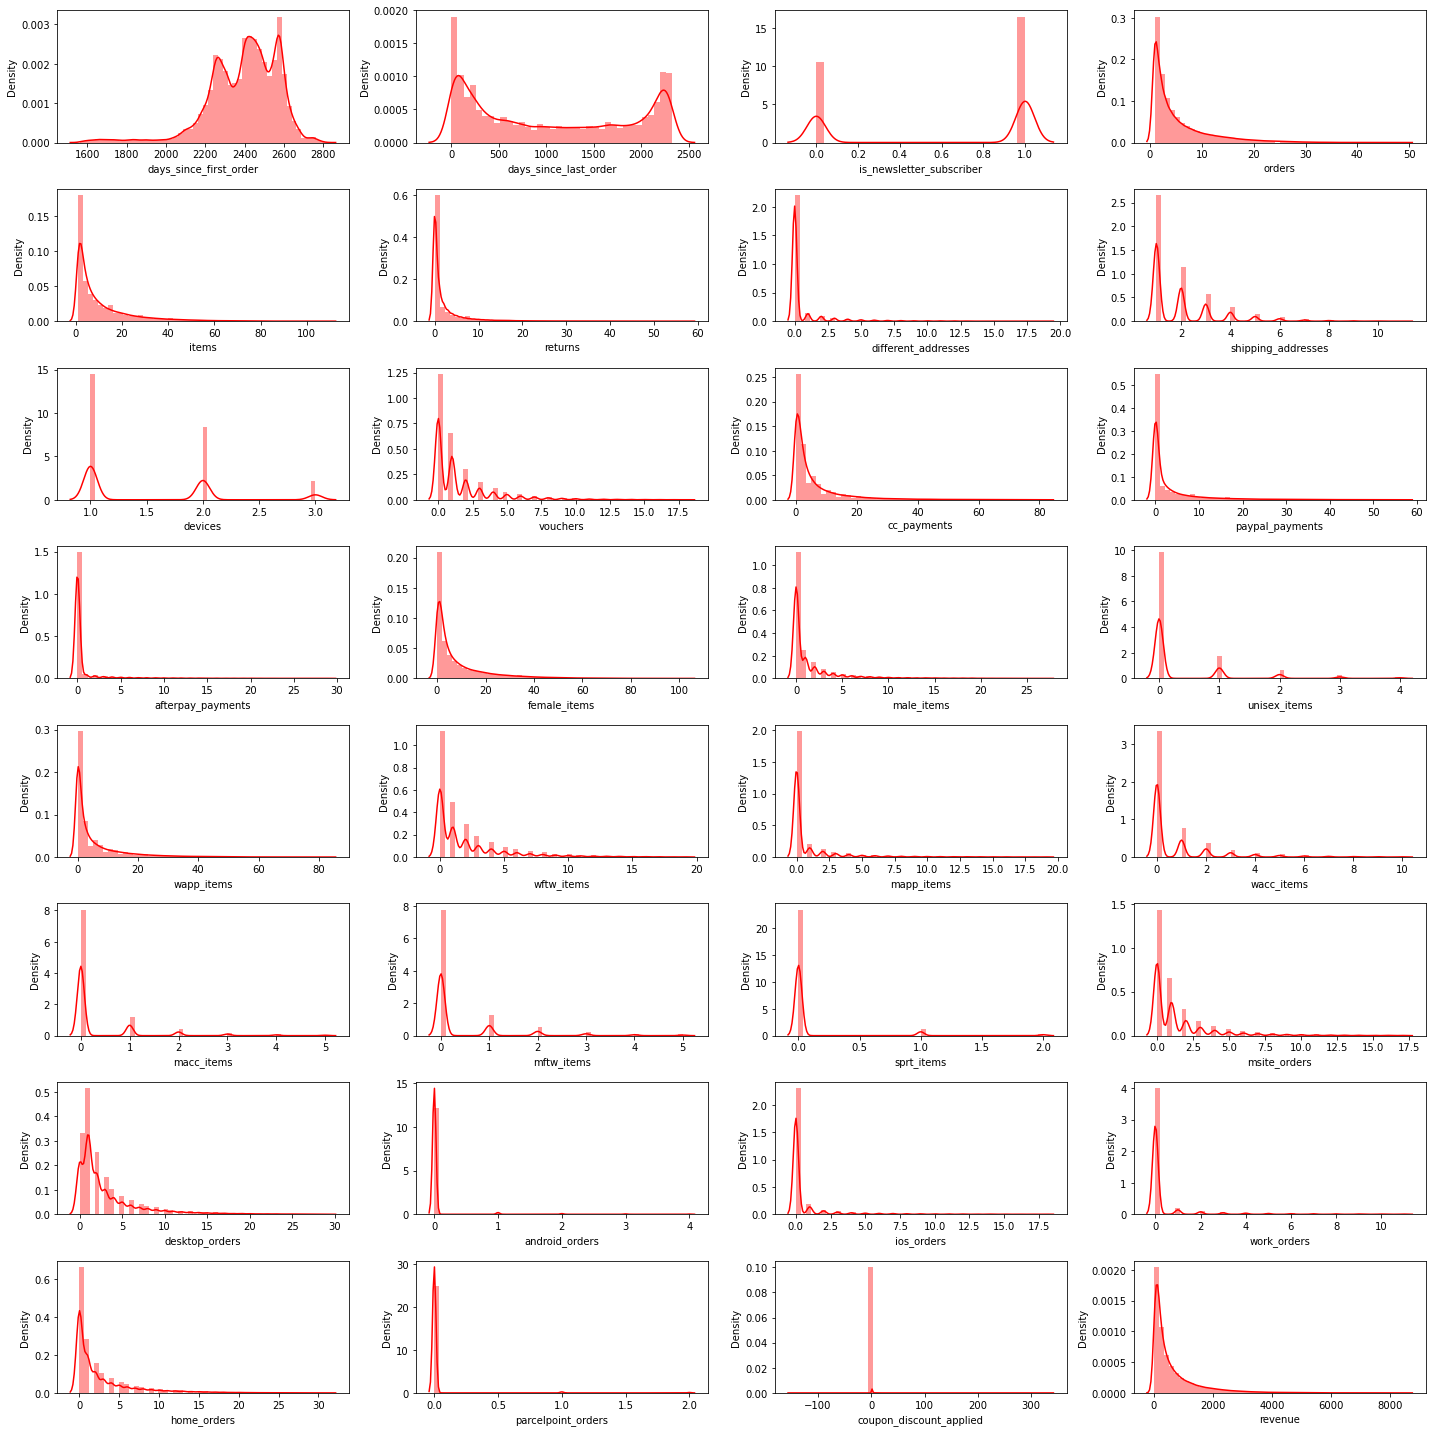

In [12]:
# Let's take a look at the same graphs without outliers 
# We drop records having any feature above 3 standard deviation.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df_raw_no_outliers = df_raw.loc[(np.abs(stats.zscore(df_raw[print_list]))<2).all(axis=1),print_list]
f, axes = plt.subplots(8,4, figsize=(20,20))

for index, col in enumerate(print_list):
    i, j = divmod(index,4)
    sns.distplot(df_raw_no_outliers[f"{col}"],ax=axes[i, j], color='red')

plt.tight_layout()
plt.show()

In [13]:
# Is there any customer having more returns than orders?

print(f"Percentage of records having 'returns' higher than 'orders': {round(df_raw.loc[df_raw['orders']<df_raw['returns']].shape[0]*100/df_raw.shape[0],1)} %")

Percentage of records having 'returns' higher than 'orders': 9.1 %


### Shipping_addresses, female_items, and male_items

In [14]:
# Let's take a look at records with 'shipping_addresses' above 100
# Maybe those customers bought goods for their numerous friends hence the number of different shipping address?...
# Looks suspicious nonetheless.

df_raw.loc[df_raw['shipping_addresses'] > 100]

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
10298,2608,1455,0,574,1099,38,1087,539,1,528,10,135,0,781,283,35,486,192,157,103,93,52,3,0,574,0,0,0,0,0,16.4487,3018.02,3.046864e+09
15833,2580,1294,0,968,1603,90,1577,936,1,898,21,106,0,1194,348,61,659,393,170,140,86,109,8,0,968,0,0,0,3,0,11.1167,7379.39,3.027101e+09
82799,2404,1216,0,639,1049,59,1030,609,2,485,12,244,0,775,253,21,427,225,113,95,51,79,12,1,638,0,0,5,2,0,3.6408,13719.01,3.274989e+09
101061,2589,588,0,1289,2374,181,1996,1122,3,1135,360,150,0,1796,503,75,1073,493,217,224,166,151,18,8,1275,0,6,0,1,0,7.7072,14651.32,3.403827e+09
106028,2595,1405,0,535,834,55,786,497,2,501,44,79,0,611,191,32,322,222,101,66,51,39,3,6,528,0,1,0,2,0,23.2940,1970.40,3.416897e+09
145400,2145,6,1,303,624,34,491,237,2,236,102,18,31,393,207,24,252,96,119,47,67,34,5,2,300,1,0,49,3,0,4.3754,5687.03,3.643409e+09


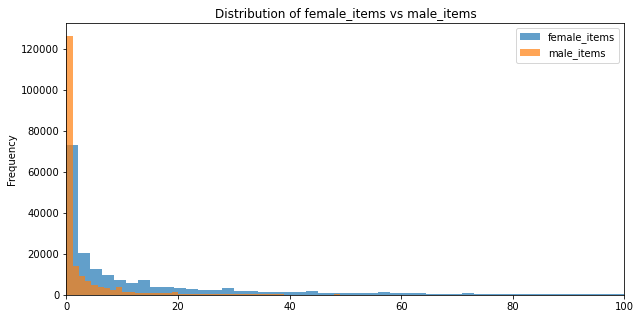

In [15]:
# Difference between female_items and male_items

fig, axes = plt.subplots(1,1,figsize=(10,5))
axes.set_title('Distribution of female_items vs male_items')

df_raw['female_items'].plot(kind='hist', bins=1000, alpha=0.7)
df_raw['male_items'].plot(kind='hist', bins=1000, alpha=0.7)

plt.legend()
plt.xlim(0,100);

# The number of female items is a lot more distributed compared to male items, which is heavely skewed towards 0.

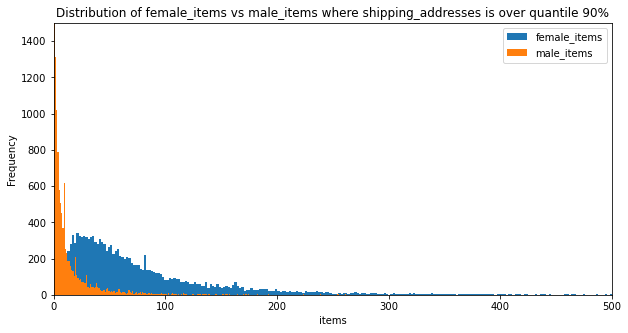

In [16]:
# Difference between female_items and male_items where shipping_addresses is over quantile 90%

fig, axes = plt.subplots(1,1,figsize=(10,5))

axes.set_title('Distribution of female_items vs male_items where shipping_addresses is over quantile 90%')
df_raw.loc[df_raw['shipping_addresses']> df_raw['shipping_addresses'].quantile(0.9),'female_items'].plot(kind='hist', bins=1000)
df_raw.loc[df_raw['shipping_addresses']> df_raw['shipping_addresses'].quantile(0.9),'male_items'].plot(kind='hist', bins=1000)

plt.legend()
axes.set_xlabel('items')
plt.xlim(0,500)
plt.ylim(0,1500);

# Again, same trend here.

In [17]:
# We have in average 5 times more female items than male items

df_raw['female_items'].sum()/df_raw['male_items'].sum()

5.312958227835781

In [18]:
# For 42% of the records, male_items or female_items is not the sum of app, acc and ftw. 

df_raw.loc[(df_raw['male_items']!=df_raw['mapp_items']+df_raw['macc_items']+df_raw['mftw_items']) | (df_raw['female_items']!=df_raw['wapp_items']+df_raw['wacc_items']+df_raw['wftw_items'])]

# Show ratio
#df_raw.loc[(df_raw['male_items']!=df_raw['mapp_items']+df_raw['macc_items']+df_raw['mftw_items']) | (df_raw['female_items']!=df_raw['wapp_items']+df_raw['wacc_items']+df_raw['wftw_items'])].shape[0]*100/df_raw.shape[0]


,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
0,2783,1487,0,2,5,0,0,2,1,0,5,0,0,0,4,1,0,0,3,0,0,2,0,0,2,0,0,0,0,0,0.0000,468.80,3.017001e+09
1,2772,1296,0,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0.0091,109.09,3.017108e+09
3,2767,6,1,23,36,3,0,3,3,13,24,0,12,28,1,7,8,11,0,2,1,4,0,8,2,0,13,0,21,0,0.1723,1872.81,3.017185e+09
5,2764,18,1,36,81,22,1,3,2,9,21,28,32,73,6,2,69,2,3,1,1,4,1,3,19,0,14,16,16,0,0.0413,7131.31,3.017256e+09
7,2757,5,1,21,58,5,1,4,2,6,30,28,0,0,55,3,0,0,41,0,11,5,0,2,19,0,0,1,10,0,0.0738,2625.62,3.017372e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191271,2083,2083,0,1,6,0,0,1,1,1,0,6,0,4,2,0,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0.2498,230.80,3.706625e+09
191278,2393,624,0,2,3,0,0,1,1,1,0,3,0,2,0,1,0,0,0,0,0,1,0,0,2,0,0,0,1,0,0.0896,141.81,3.706942e+09
191279,2132,154,0,3,8,0,3,3,1,0,0,7,1,7,1,0,2,4,0,1,0,0,0,0,3,0,0,0,1,0,0.0022,442.49,3.706952e+09
191280,2234,32,1,187,835,673,28,4,4,55,832,2,0,753,60,22,638,52,43,45,12,11,26,3,130,5,49,0,170,0,0.2099,68349.19,3.706954e+09


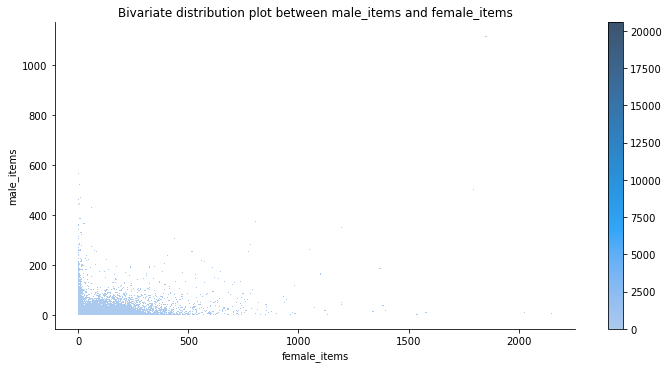

In [19]:
# Is there any obvious relationship between male_items and female_items? Hard to say...

sns.displot(data=df_raw,x='female_items', y='male_items',cbar=True, aspect=2)
plt.title('Bivariate distribution plot between male_items and female_items');

### Items and returns

In [20]:
# Records where items is very high and the ratio of returns versus items is also high (more than 97% of the records)

it_qu = df_raw['items'].quantile(0.97)
ratio_qu = (df_raw['returns']/df_raw['items']).quantile(0.97)

df_not_happy = df_raw[(df_raw['items'] > it_qu) & (df_raw['returns']/df_raw['items'] > ratio_qu)]
df_not_happy

# It looks like those customers are often unhappy about their purchases...

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
434,2727,36,1,29,171,136,0,2,2,6,171,0,0,171,0,0,161,7,0,1,0,0,0,3,3,0,23,29,0,0,0.0289,11807.06,3.035680e+09
1380,1930,29,1,81,203,171,0,2,4,24,203,0,0,165,33,5,98,63,24,4,6,5,0,8,22,0,51,0,76,0,0.1568,12109.75,3.071641e+09
1421,2600,15,1,59,158,122,43,4,2,26,117,1,40,157,1,0,133,14,0,7,1,0,1,0,29,0,30,23,19,0,0.1017,11066.28,3.073042e+09
2332,2524,5,1,275,513,409,62,16,4,60,23,176,314,467,18,28,388,41,3,35,12,16,1,51,104,0,120,90,130,0,0.1096,43952.80,3.107201e+09
3385,2232,13,1,126,301,264,0,1,2,29,301,0,0,294,0,7,271,19,1,4,3,0,1,8,87,0,31,0,113,0,0.0648,30953.32,3.021650e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188937,2111,41,1,41,203,161,8,3,4,13,78,122,0,183,12,8,137,37,9,8,7,2,0,3,14,0,24,2,36,0,0.1980,14373.19,3.722216e+09
190627,2225,34,0,55,200,165,0,4,3,22,50,45,105,197,1,2,124,51,0,18,0,2,1,6,48,0,1,1,42,0,0.2194,8133.41,3.732393e+09
190824,2207,26,1,130,320,258,0,1,4,47,320,0,0,311,6,3,199,75,5,32,1,2,3,2,65,0,63,0,114,0,0.1286,19845.60,3.738113e+09
191226,2401,6,1,221,393,315,12,20,4,80,118,33,241,366,8,19,310,30,12,26,6,0,4,7,66,0,148,31,153,0,0.1530,28865.52,3.704876e+09


In [21]:
# Items is the sum of female_items, male_items and unisex_items. As it does not provide additional information, I will therefore drop it later on.

df_raw.loc[df_raw['items']!=df_raw['female_items']+df_raw['male_items']+df_raw['unisex_items']]

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id


### Coupon_discount_applied

In [22]:
# 'coupon_discount_applied' is the average discount rate applied via coupon based discount e.g. SAVE15. 
# There shouldn't be any negative value nor value exceeding 100% (free item).

df_raw['coupon_discount_applied'].sort_values()

25588    -1.559784e+02
0         0.000000e+00
111543    0.000000e+00
111544    0.000000e+00
111547    0.000000e+00
              ...     
147970    3.587900e+06
92881     3.839500e+06
18506     3.997600e+06
153627    4.541400e+06
147757    5.798000e+06
Name: coupon_discount_applied, Length: 191287, dtype: float64

In [23]:
df_raw['coupon_discount_applied'].describe()

count    1.912870e+05
mean     1.321704e+03
std      3.905356e+04
min     -1.559784e+02
25%      4.800000e-03
50%      5.520000e-02
75%      1.466000e-01
max      5.798000e+06
Name: coupon_discount_applied, dtype: float64

Percentage of coupon over 100%: 0.7062685911745179


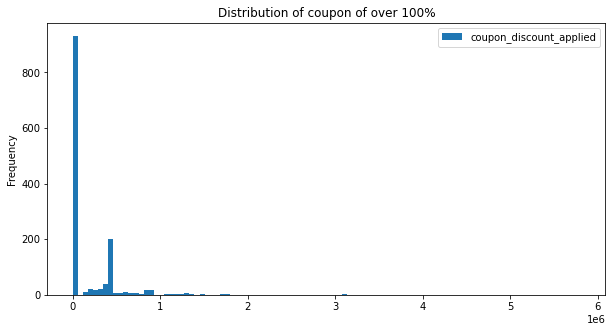

In [24]:
# Taking a look at the coupon over 100%.
print(f"Percentage of coupon over 100%: {df_raw.loc[df_raw['coupon_discount_applied'] >= 1, 'coupon_discount_applied'].count()*100/df_raw.shape[0]}")

plt.figure(figsize=(10,5))
df_raw.loc[df_raw['coupon_discount_applied'] >= 1, 'coupon_discount_applied'].sort_values().reset_index(drop=True).plot(kind='hist', bins=100)
plt.legend()
plt.title('Distribution of coupon of over 100%');


### Revenue

In [25]:
# Revenue = $ Dollar spent overall per person. 
# There shouldn't be any negative value.
df_raw['revenue'].sort_values()

25588         -1.13
98595          0.00
158964         0.00
155432         0.00
152966         0.00
            ...    
153209    144518.41
128744    149182.19
5698      162312.55
25190     165326.80
117175    205655.02
Name: revenue, Length: 191287, dtype: float64

In [26]:
df = df_raw.copy()

In [27]:
# Let's replace the negative value by 0. We will tackle the 0 values later on.

df.loc[df['revenue']<0,'revenue'] = 0

In [28]:
# Let's take a look at records having a revenue/items ratio of less than 1.

df_small_revenue = df[['items','revenue']].copy()
df_small_revenue['ratio'] = df['revenue']/df['items']
df_small_revenue.loc[df_small_revenue['ratio']<=1].sort_values(by='ratio')

# Those records look suspicious. 
# Maybe one reason for having items that didn't generate revenue could be free gift?...
# I think it would be wise to replace those 0 later.

,items,revenue,ratio
1543,1,0.00,0.00
154005,1,0.00,0.00
153999,1,0.00,0.00
153667,2,0.00,0.00
153627,9,0.00,0.00
...,...,...,...
90171,1,0.87,0.87
190078,2,1.74,0.87
175848,1,0.87,0.87
76563,1,0.89,0.89


In [29]:
# Is the average revenue per item (for revenue and revenue/items ratio over quantile 90%) disproportionate? 

big_revenue = df['revenue'] > df['revenue'].quantile(0.9)
big_ratio = df['revenue']/df['items'] > (df['revenue']/df['items']).quantile(0.9)

df_average_revenue_per_item = df.loc[(big_revenue) & (big_ratio),['items','revenue']]
df_average_revenue_per_item['average_revenue_per_item'] = df_average_revenue_per_item['revenue']/df_average_revenue_per_item['items']
df_average_revenue_per_item.sort_values(by='average_revenue_per_item', ascending=False)

# This looks fine to me.

,items,revenue,average_revenue_per_item
104461,11,4074.46,370.405455
73712,22,8103.23,368.328636
122660,11,4039.38,367.216364
165856,13,3955.79,304.291538
26084,16,4570.68,285.667500
...,...,...,...
56608,36,3863.69,107.324722
113375,42,4507.03,107.310238
73766,424,45485.15,107.276297
185579,328,35186.19,107.274970


In [30]:
df_average_revenue_per_item['average_revenue_per_item'].describe()

# Nothing much to comment here

count    1415.000000
mean      130.958592
std        27.543073
min       107.268649
25%       113.816379
50%       122.441724
75%       138.057589
max       370.405455
Name: average_revenue_per_item, dtype: float64

In [31]:
# Checking the items where the revenue is 0

df.loc[df['revenue']==0,'items'].value_counts().index

Int64Index([1, 2, 3, 5, 4, 6, 7, 9, 8, 13, 12], dtype='int64')

In [32]:
# Replacing each 'revenue' having 0 by the median of revenue for its specific number of items (1 to 13)

for i in df.loc[df['revenue']==0,'items'].value_counts().index:  
    replace = df.loc[df['revenue'] != 0].groupby('items')['revenue'].median()[i]
    print(f"median for {i} items = {replace}")
    print('')
    print(df.loc[(df['revenue']==0) & (df['items']==i),['items','revenue']])
    print('')
    df.loc[(df['revenue']==0) & (df['items']==i),'revenue']  = replace

median for 1 items = 63.61

        items  revenue
1543        1      0.0
7588        1      0.0
9342        1      0.0
11278       1      0.0
11560       1      0.0
...       ...      ...
188594      1      0.0
190056      1      0.0
190092      1      0.0
190923      1      0.0
191267      1      0.0

[291 rows x 2 columns]

median for 2 items = 109.05

        items  revenue
1614        2      0.0
17574       2      0.0
19010       2      0.0
24031       2      0.0
29814       2      0.0
...       ...      ...
184620      2      0.0
186319      2      0.0
187197      2      0.0
187375      2      0.0
187933      2      0.0

[95 rows x 2 columns]

median for 3 items = 163.49

        items  revenue
1619        3      0.0
7364        3      0.0
49288       3      0.0
59681       3      0.0
78481       3      0.0
88799       3      0.0
90679       3      0.0
93086       3      0.0
93594       3      0.0
99517       3      0.0
100450      3      0.0
106961      3      0.0
114777      3 

In [33]:
# Let's take a look at the big revenue in details

list_avg_max = []
for i in sorted(df['items'].unique()):
    print(f"For {i} items the average max revenue is {df.loc[df['items']==i,'revenue'].max()/i}")
    list_avg_max.append(df.loc[df['items']==i,'revenue'].max()/i)

For 1 items the average max revenue is 981.82
For 2 items the average max revenue is 680.905
For 3 items the average max revenue is 545.75
For 4 items the average max revenue is 498.185
For 5 items the average max revenue is 335.268
For 6 items the average max revenue is 319.955
For 7 items the average max revenue is 314.14285714285717
For 8 items the average max revenue is 362.49
For 9 items the average max revenue is 300.7688888888889
For 10 items the average max revenue is 328.569
For 11 items the average max revenue is 370.4054545454546
For 12 items the average max revenue is 198.10333333333332
For 13 items the average max revenue is 304.29153846153844
For 14 items the average max revenue is 254.95499999999998
For 15 items the average max revenue is 276.59000000000003
For 16 items the average max revenue is 285.6675
For 17 items the average max revenue is 270.7117647058824
For 18 items the average max revenue is 238.67166666666668
For 19 items the average max revenue is 216.58
For 

For 158 items the average max revenue is 160.3510759493671
For 159 items the average max revenue is 148.1374213836478
For 160 items the average max revenue is 104.2266875
For 161 items the average max revenue is 107.85906832298137
For 162 items the average max revenue is 157.8120987654321
For 163 items the average max revenue is 110.6978527607362
For 164 items the average max revenue is 96.13006097560975
For 165 items the average max revenue is 106.61084848484849
For 166 items the average max revenue is 113.5794578313253
For 167 items the average max revenue is 99.41203592814372
For 168 items the average max revenue is 143.27255952380952
For 169 items the average max revenue is 116.45970414201183
For 170 items the average max revenue is 127.34982352941176
For 171 items the average max revenue is 158.4861403508772
For 172 items the average max revenue is 109.30912790697674
For 173 items the average max revenue is 176.13312138728324
For 174 items the average max revenue is 89.71632183908

For 320 items the average max revenue is 102.53118750000002
For 321 items the average max revenue is 70.87598130841121
For 322 items the average max revenue is 186.85440993788822
For 323 items the average max revenue is 88.1643653250774
For 324 items the average max revenue is 81.41385802469136
For 325 items the average max revenue is 75.40944615384615
For 326 items the average max revenue is 99.08601226993865
For 327 items the average max revenue is 151.64318042813454
For 328 items the average max revenue is 107.27496951219513
For 329 items the average max revenue is 92.04343465045594
For 330 items the average max revenue is 72.78978787878788
For 331 items the average max revenue is 79.91172205438066
For 332 items the average max revenue is 56.70686746987952
For 333 items the average max revenue is 139.71342342342342
For 334 items the average max revenue is 64.98287425149701
For 335 items the average max revenue is 166.94874626865672
For 336 items the average max revenue is 82.1057440

For 511 items the average max revenue is 80.46344422700587
For 512 items the average max revenue is 83.616640625
For 513 items the average max revenue is 85.67797270955167
For 514 items the average max revenue is 86.95700389105059
For 516 items the average max revenue is 64.81031007751939
For 517 items the average max revenue is 49.28112185686654
For 518 items the average max revenue is 56.58040540540541
For 519 items the average max revenue is 50.43314065510597
For 520 items the average max revenue is 53.53373076923077
For 521 items the average max revenue is 94.40028790786948
For 524 items the average max revenue is 95.08040076335877
For 525 items the average max revenue is 67.26300952380953
For 527 items the average max revenue is 67.43986717267552
For 528 items the average max revenue is 86.50696969696969
For 530 items the average max revenue is 77.05466037735849
For 533 items the average max revenue is 28.346810506566605
For 534 items the average max revenue is 64.80438202247191
F

For 2209 items the average max revenue is 93.09869624264373
For 2374 items the average max revenue is 6.171575400168492
For 3020 items the average max revenue is 54.743973509933774


In [34]:
pd.Series(list_avg_max).describe()

count    674.000000
mean     109.473350
std       69.420527
min        2.746151
25%       73.447266
50%       94.685803
75%      129.305719
max      981.820000
dtype: float64

In [35]:
# Those are the high revenue in regards to the items. These records might be seen as outliers.

pd.Series(list_avg_max).loc[np.abs(stats.zscore(pd.Series(list_avg_max)))>3]

0     981.820000
1     680.905000
2     545.750000
3     498.185000
4     335.268000
5     319.955000
7     362.490000
9     328.569000
10    370.405455
21    368.328636
dtype: float64

In [36]:
# A look at the big revenues

list_big_revenue = pd.Series(list_avg_max).loc[np.abs(stats.zscore(pd.Series(list_avg_max)))>3].tolist()
df.loc[(df['revenue']/df['items']).isin(list_big_revenue)]

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
24476,1406,452,1,10,10,1,0,2,1,0,10,0,0,10,0,0,9,1,0,0,0,0,0,0,10,0,0,0,10,0,0.0003,3285.69,3.030160e+09
46981,1318,159,0,3,3,0,0,2,2,1,0,3,0,2,1,0,0,2,0,0,1,0,0,2,1,0,0,0,3,0,0.0055,1637.25,3.156814e+09
64601,2669,928,1,8,8,4,0,5,2,0,8,0,0,8,0,0,6,2,0,0,0,0,0,8,0,0,0,0,5,0,0.0000,2899.92,3.213947e+09
65881,2406,257,1,6,6,4,0,1,1,2,6,0,0,6,0,0,6,0,0,0,0,0,0,0,6,0,0,0,6,0,0.1731,1919.73,3.267805e+09
73712,1768,1031,1,10,22,1,0,3,1,3,20,2,0,19,3,0,17,1,3,1,0,0,0,0,10,0,0,7,0,0,0.0882,8103.23,3.321476e+09
91482,2332,207,1,3,5,0,0,2,1,0,3,2,0,5,0,0,5,0,0,0,0,0,0,1,0,0,2,0,2,0,0.0005,1676.34,3.370639e+09
104461,2361,111,1,8,11,1,0,4,1,1,0,11,0,10,0,1,8,3,0,0,0,0,0,8,0,0,0,2,5,0,0.0295,4074.46,3.422682e+09
118726,2488,1165,1,1,2,0,0,1,1,0,2,0,0,2,0,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0.0007,1361.81,3.509139e+09
142344,2376,2187,0,4,4,2,0,1,1,2,2,0,0,4,0,0,4,0,0,0,0,0,0,0,4,0,0,0,0,0,0.0857,1992.74,3.568523e+09
174486,2476,1168,1,1,1,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.3333,981.82,3.692687e+09


## Preliminary Exploration before Machine Learning models

In [37]:
df_cleaned = df_raw.copy()

# Convert 'is_newsletter_subscriber' into 1 or 0 (1='Yes', 0 ='No').
df_cleaned['is_newsletter_subscriber'] = np.where(df_cleaned['is_newsletter_subscriber']=='Y',1,0)

''' Features engineering'''

# Create another feature for the average of revenue spend per item
df_cleaned['avg_revenue_per_item'] = df_cleaned['revenue']/df_cleaned['items']

# Create another feature for the number of items per order
df_cleaned['items_per_order'] = df_cleaned['items']/df_cleaned['orders']

# Create another feature for the number of returns
df_cleaned['returns_per_item'] = df_cleaned['returns']*100/df_cleaned['items']

# Create another feature for the online orders
df_cleaned['online_orders'] = (df_cleaned['msite_orders'] + df_cleaned['desktop_orders'] + df_cleaned['android_orders'] + df_cleaned['ios_orders'])/ df_cleaned['orders']

# Create another feature for the shipped items
df_cleaned['shipped_items'] = (df_cleaned['work_orders'] + df_cleaned['home_orders'] + df_cleaned['parcelpoint_orders'])/ df_cleaned['orders']

# Create another feature for female items
df_cleaned['f_items'] = df_cleaned['female_items'] + df_cleaned['wapp_items'] + df_cleaned['wacc_items'] + df_cleaned['wftw_items']

# Create another feature for male items
df_cleaned['m_items'] = df_cleaned['male_items'] + df_cleaned['mapp_items'] + df_cleaned['macc_items'] + df_cleaned['mftw_items']

# Create another feature for the sum of payment method
df_cleaned['electronic_payment'] = (df_cleaned['cc_payments'] + df_cleaned['paypal_payments'] + df_cleaned['afterpay_payments'])/ df_cleaned['orders']

''' Creation of labels for "obvious" customers'''

# df_cleaned = df_cleaned.loc[(np.abs(stats.zscore(df_cleaned.drop('is_newsletter_subscriber',axis=1)))<3).all(axis=1)]
df_cleaned = df_cleaned.loc[(df_cleaned['male_items']+df_cleaned['female_items']>=10) & (df_cleaned[['female_items','male_items']].max(axis=1)/df_cleaned[['female_items','male_items']].min(axis=1)>=4)]

df_cleaned.loc[df_cleaned['female_items']/df_cleaned['male_items']>= 4,'label_created'] = 1
df_cleaned.loc[df_cleaned['male_items']/df_cleaned['female_items']>= 4,'label_created'] = 0

remove_sample = df_cleaned['label_created'].value_counts().max() - df_cleaned['label_created'].value_counts().min()
drop_indices = np.random.choice(df_cleaned.loc[df_cleaned['label_created']==df_cleaned['label_created'].value_counts().index[0]].index, remove_sample, replace=False)
df_cleaned = df_cleaned.drop(drop_indices)

# Replace the negative 'revenue' value by 0
df_cleaned.loc[df_cleaned['revenue']<0,'revenue'] = 0

# Replace each 'revenue' having 0 by the median of revenue for its specific number of items (1 to 13)
for i in df_cleaned.loc[df_cleaned['revenue']==0,'items'].value_counts().index:  
    replace = df_cleaned.loc[df_cleaned['revenue'] != 0].groupby('items')['revenue'].median()[i]
    df_cleaned.loc[(df_cleaned['revenue']==0) & (df_cleaned['items']==i),'revenue'] = replace


In [38]:
df_cleaned['label_created'].value_counts()

1.0    9790
0.0    9790
Name: label_created, dtype: int64

In [39]:
df_mean = df_cleaned.groupby('label_created').mean()
df_mean

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id,avg_revenue_per_item,items_per_order,returns_per_item,online_orders,shipped_items,f_items,m_items,electronic_payment
label_created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,2392.304494,553.301124,0.0,13.135546,33.264658,4.811645,2.079775,3.012564,1.839122,4.159040,20.197446,9.766190,2.409704,1.003473,30.398876,1.862308,0.466905,0.300409,20.910215,0.311440,4.527886,5.478958,0.538202,2.002656,8.538304,0.387743,2.206844,1.359244,6.542799,0.155363,0.117003,1752.737293,3.383603e+09,52.001427,2.843431,11.967068,1.0,0.543683,2.082227,61.315935,2.770607
1.0,2367.757712,314.787538,0.0,23.171195,54.487743,17.966803,2.639632,3.709908,2.153933,7.419816,29.090501,17.493156,6.861287,50.569459,2.499591,1.418693,36.226864,9.242697,1.445046,4.137998,0.864964,0.754239,0.439939,5.855260,11.639837,0.475996,5.200102,2.875689,13.491318,0.225332,0.115830,3431.072553,3.366967e+09,62.278613,2.398098,25.746847,1.0,0.666725,100.177017,5.563841,2.357458


In [40]:
df_med = df_cleaned.groupby('label_created').median()
df_med

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id,avg_revenue_per_item,items_per_order,returns_per_item,online_orders,shipped_items,f_items,m_items,electronic_payment
label_created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,2437.0,263.0,0.0,10.0,22.0,1.0,0.0,3.0,2.0,3.0,13.0,2.0,0.0,0.0,20.0,1.0,0.0,0.0,13.0,0.0,3.0,4.0,0.0,1.0,6.0,0.0,0.0,0.0,4.0,0.0,0.08815,1155.145,3.390210e+09,49.502966,2.428571,6.250000,1.0,0.592906,0.0,41.0,2.375000
1.0,2436.0,91.5,0.0,15.0,31.0,6.0,0.0,3.0,2.0,5.0,14.0,6.0,0.0,29.0,1.0,0.0,20.0,6.0,0.0,2.0,0.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,8.0,0.0,0.09610,1916.190,3.365544e+09,58.197000,2.128388,21.545093,1.0,0.731707,57.5,2.0,2.090909


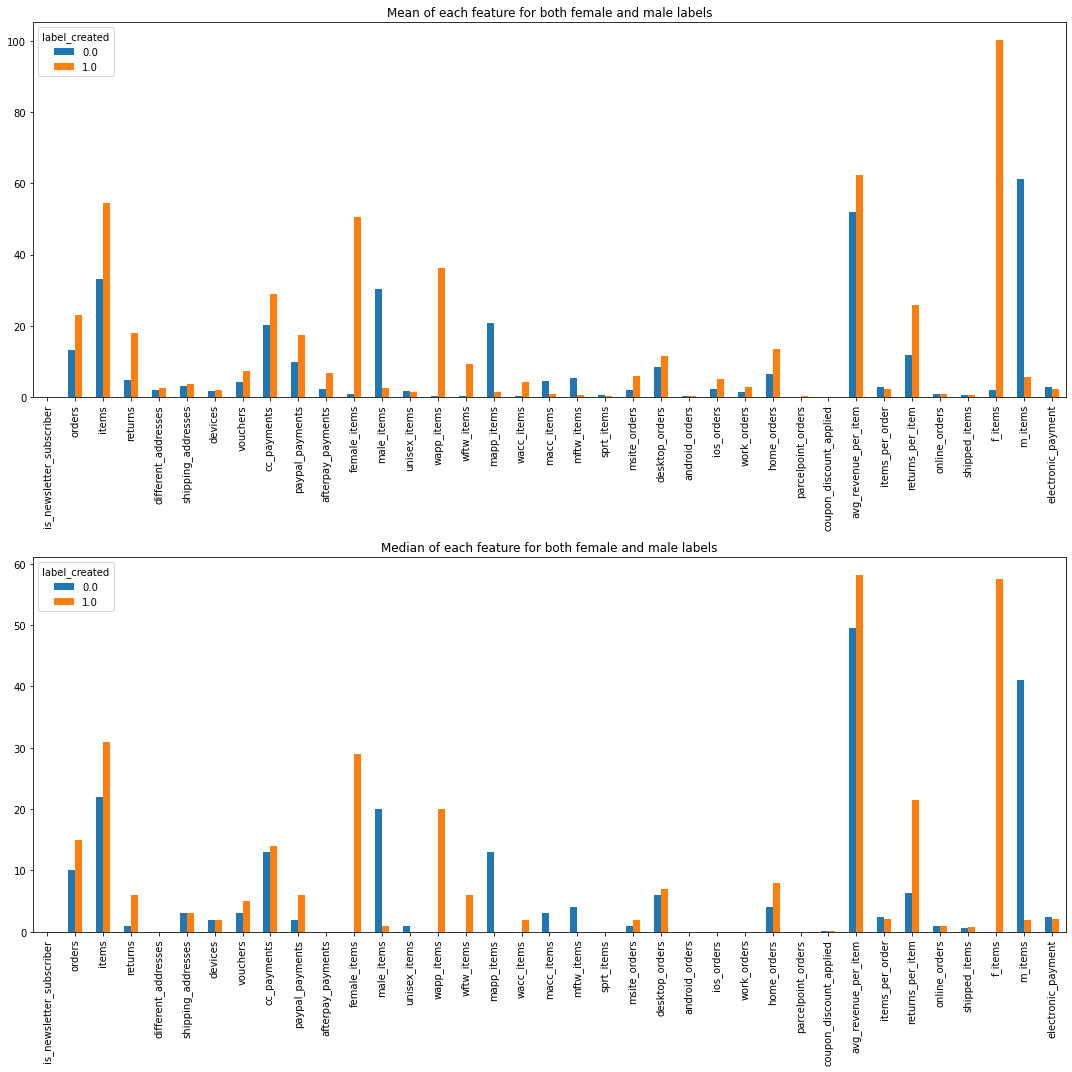

In [41]:
# Plot mean and median of each feature

fig, axes = plt.subplots(2,1,figsize=(15,15))

df_mean[df_mean<=102].dropna(axis=1).T.plot(kind='bar', ax=axes[0])
df_med[df_med<=102].dropna(axis=1).T.plot(kind='bar', ax=axes[1])

axes[0].set_title('Mean of each feature for both female and male labels')
axes[1].set_title('Median of each feature for both female and male labels')

plt.tight_layout();

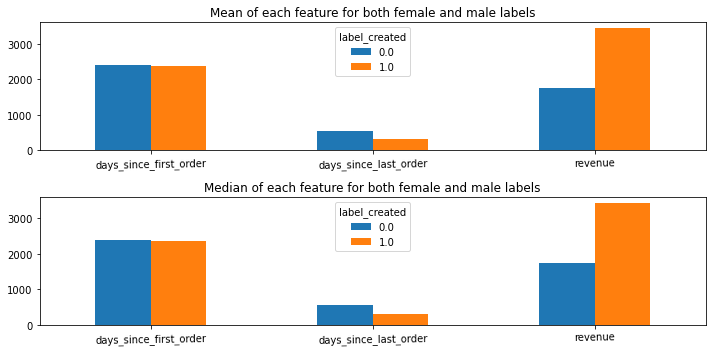

In [42]:
# Plot last 3 features

fig, axes = plt.subplots(2,1,figsize=(10,5))

df_mean[['days_since_first_order','days_since_last_order','revenue']].T.plot(kind='bar', ax=axes[0], rot=1)
df_mean[['days_since_first_order','days_since_last_order','revenue']].T.plot(kind='bar', ax=axes[1], rot=1)

axes[0].set_title('Mean of each feature for both female and male labels')
axes[1].set_title('Median of each feature for both female and male labels')


plt.tight_layout();

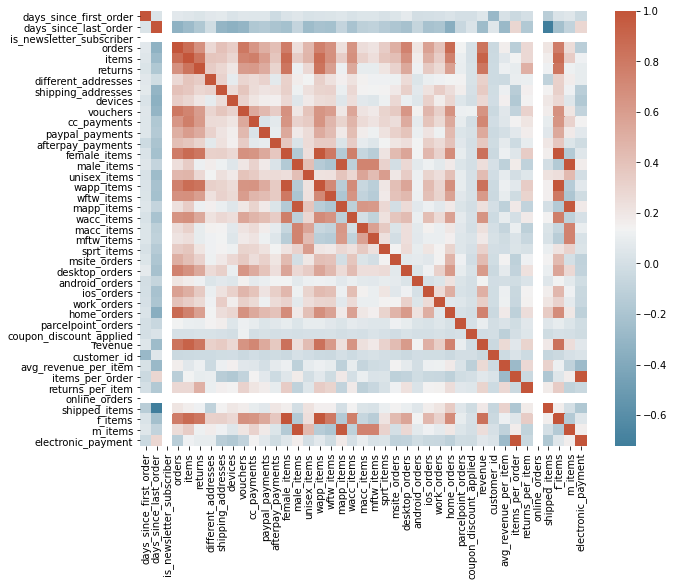

In [43]:
# A look at the correlation between features

plt.figure(figsize=(10,8))
sns.heatmap(df_cleaned.drop('label_created', axis=1).corr(), cmap=sns.diverging_palette(230, 20, as_cmap=True));

In [44]:
# A look at the features with more than 70% correlation

correlated_features = set()
correlation_matrix = df_cleaned.drop('label_created', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_features.add(colname1)
            correlated_features.add(colname2)

correlated_features

{'cc_payments',
 'days_since_last_order',
 'desktop_orders',
 'electronic_payment',
 'f_items',
 'female_items',
 'home_orders',
 'items',
 'items_per_order',
 'm_items',
 'macc_items',
 'male_items',
 'mapp_items',
 'mftw_items',
 'orders',
 'returns',
 'revenue',
 'shipped_items',
 'vouchers',
 'wacc_items',
 'wapp_items',
 'wftw_items'}

In [46]:
print("Let's keep the features 'days_since_last_order', 'orders', 'avg_revenue_per_item', 'f_items','m_items', 'returns_per_item'")

Let's keep the features 'days_since_last_order', 'orders', 'avg_revenue_per_item', 'f_items','m_items', 'returns_per_item'


In [47]:
df_cleaned = df_cleaned[['days_since_last_order', 'orders', 'avg_revenue_per_item', 'f_items','m_items','returns_per_item', 'label_created']]

In [48]:
# Do we still have correlated features?

correlated_features = set()
correlation_matrix = df_cleaned.drop(['label_created'], axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_features.add(colname1)
            correlated_features.add(colname2)

print(f"Now we have {len(correlated_features)} correlated features in our dataset")

Now we have 0 correlated features in our dataset


In [49]:
# Create X_ and y_ in order to look at feature importance

X_ = df_cleaned.drop('label_created', axis=1).values
y_ = df_cleaned['label_created'].values

In [50]:
# Using recursive feature elimination and cross-validated section to judge of the importance of the features

rfecv = RFECV(estimator=LogisticRegression(max_iter=500), step=1, scoring='accuracy')
rfecv.fit(X_, y_)

RFECV(estimator=LogisticRegression(max_iter=500), scoring='accuracy')

In [51]:
# The most significant features

df_cleaned.columns[np.where(rfecv.support_ == True)[0]]

Index(['f_items', 'm_items'], dtype='object')

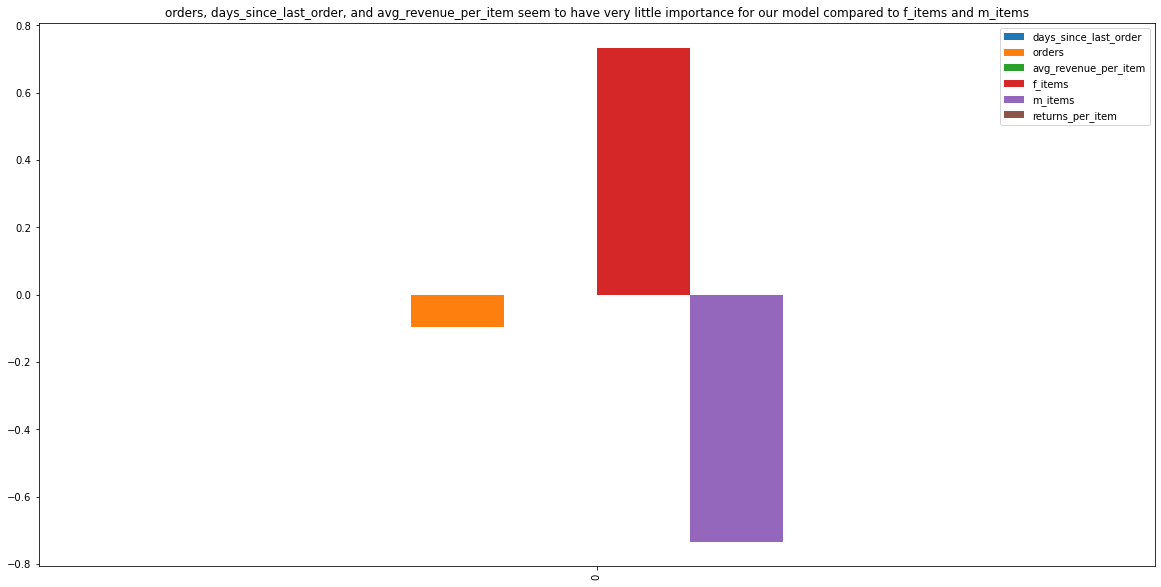

In [52]:
# Ploting the features coefficients with regards to Logistic Regression model

logr = LogisticRegression(max_iter=500)
logr.fit(X_, y_)
df_to_plot = pd.DataFrame(logr.coef_,columns=df_cleaned.drop('label_created', axis=1).columns)
df_to_plot.plot(kind='bar', figsize=(20,10))
plt.title("orders, days_since_last_order, and avg_revenue_per_item seem to have very little importance for our model compared to f_items and m_items");